In [12]:
import numpy
import scipy
import netCDF4
import matplotlib.pyplot as mp
import matplotlib.ticker
import matplotlib.colors
import scipy.stats
import pandas
import itertools
import datetime
import os

% matplotlib inline

In [13]:
mp.rcParams.update({'mathtext.default': 'regular'})
#get_ipython().magic('matplotlib inline')

# ======================================================================

PRECT_nlat = 26
PRECT_nlon = 25

latlon_indices = list(itertools.product(range(PRECT_nlat), range(PRECT_nlon)))
region = 'whole_domain'
window=1

PRECT_lat = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/PRECT_lat.npy')
PRECT_lon = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/PRECT_lon.npy')

# ======================================================================

#working_dir = '/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/'

#latlon_indices = numpy.load(working_dir + 'ncal_latlon_indices_array.npy'); region='ncal'
#latlon_indices = numpy.load(working_dir + 'ccal_latlon_indices_array.npy'); region='ccal'
#latlon_indices = numpy.load(working_dir + 'scal_latlon_indices_array.npy'); region='scal'

threshold = 0.1

year_start_pic = 402 #time_subsets[chunk,0]
year_end_pic = 2200 #time_subsets[chunk,1]

year_start = 1920
year_end = 2100

lo_perc = 20
hi_perc = 80

#year_start_whiplash = 1920
#year_end_whiplash = 1950

year_start_list = numpy.arange(1920,2100)
#year_end_list = numpy.arange(1950,2101)

whiplash_ratios_all = numpy.zeros(( year_start_list.size, len(latlon_indices) ))
whiplash_counts_pic_all = numpy.zeros(( year_start_list.size, len(latlon_indices) ))
whiplash_counts_rcp_all = numpy.zeros(( year_start_list.size, len(latlon_indices) ))

# create list of names of members '001','002','003', ...
ensemble_members = numpy.hstack((numpy.arange(1,36), numpy.arange(101,106)))
ensemble_names = ['{:03d}'.format(i) for i in ensemble_members]

working_dir = '/Users/baird/Dropbox/_data_original/NCAR_LENS/daily/PRECT/calculated_npy_files/whole_domain/'

# create season strings for PIC
years_pic = numpy.arange(year_start_pic, year_end_pic+1, 1).astype(numpy.int)
half_years_pic = numpy.arange(year_start_pic+0.75, year_end_pic, 1)

season_strings_pic = [str(years_pic[i])+'-'+str(years_pic[i+1]) for i in range(years_pic.size-1)]
member_strings_pic = ['{:03d}'.format(i) for i in range(1,36)]
n_seasons_pic=year_end_pic-year_start_pic

# ========== open pic
ncfile = netCDF4.Dataset('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/calcs_and_plots/create_ncfiles_seasonal/'+\
                       'seasonal_totals_pic.nc', 'r', 'NETCDF4')
seasonal_totals_pic = ncfile.variables['seasonal_total'][:]
seasonal_totals_pic = seasonal_totals_pic.reshape((1798,-1))

# ========== open hist+rcp
ncfile = netCDF4.Dataset('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/calcs_and_plots/create_ncfiles_seasonal/'+\
                       'seasonal_totals_hist_rcp.nc', 'r', 'NETCDF4')
seasonal_totals_hist_rcp = ncfile.variables['seasonal_total'][:]
seasonal_totals_hist_rcp = seasonal_totals_hist_rcp.reshape((180,40,-1))

all_hist_rcp_markers = numpy.zeros((180,40,len(latlon_indices)), dtype=numpy.int)
all_pic_markers = numpy.zeros((1798,len(latlon_indices)), dtype=numpy.int)

In [14]:
LA_lat = 34.0522
LA_lon = 118.2437 # deg west
LA_lon = 180. + (180-LA_lon)

Oroville_dam_lat = 39.5380
Oroville_dam_lon = 121.4831 # deg west
Oroville_dam_lon = 360 - Oroville_dam_lon

SF_lat = 37.7749
SF_lon = 122.4194
SF_lon = 360 - SF_lon

In [15]:
def geo_idx(dd, dd_array):
   """
     search for nearest decimal degree in an array of decimal degrees and return the index.
     np.argmin returns the indices of minium value along an axis.
     so subtract dd from all values in dd_array, take absolute value and find index of minium.
    """
   geo_idx = (numpy.abs(dd_array - dd)).argmin()
   return geo_idx

In [16]:
LA_lat_idx = geo_idx(LA_lat, PRECT_lat)
LA_lon_idx = geo_idx(LA_lon, PRECT_lon)

SF_lat_idx = geo_idx(SF_lat, PRECT_lat)
SF_lon_idx = geo_idx(SF_lon, PRECT_lon)

OD_lat_idx = geo_idx(Oroville_dam_lat, PRECT_lat)
OD_lon_idx = geo_idx(Oroville_dam_lon, PRECT_lon)

#REGION_lat_idx, REGION_lon_idx = SF_lat_idx, SF_lon_idx; REGION_NAME = 'SF'
REGION_lat_idx, REGION_lon_idx = LA_lat_idx, LA_lon_idx; REGION_NAME = 'LA'
#REGION_lat_idx, REGION_lon_idx = OD_lat_idx, OD_lon_idx; REGION_NAME = 'OD'

In [17]:
all_pic_markers.shape

(1798, 650)

In [18]:
seasonal_total_pic.shape

(1798,)

In [19]:
for latlon_idx in range(len(latlon_indices)):

    #if latlon_idx%10==0:
    #    print('latlon_idx', latlon_idx)

    # ======================================================================
    # Open preindustrial control info (dict_pic)
    seasonal_total_pic = seasonal_totals_pic[:,latlon_idx]
    #print(seasonal_total_pic)
    
    # ======================================================================
    # ======================================================================
    # ======================================================================
    # whiplash calculation setup
    # get top and bottom 10th percentiles in PIC
    # then see how often it transitions from 1 or 2 seasons with that

    pic_hi = numpy.percentile(seasonal_total_pic, hi_perc)

    # take 3 year running mean for pic_lo
    seasonal_total_pic_window_mean = numpy.array(pandas.Series(seasonal_total_pic).rolling(window=window).mean())
    pic_lo = numpy.nanpercentile(seasonal_total_pic_window_mean, lo_perc)

    all_pic_markers[:,latlon_idx][ seasonal_totals_pic[:,latlon_idx] < pic_lo] = -1    
    all_pic_markers[:,latlon_idx][ seasonal_totals_pic[:,latlon_idx] > pic_hi] = 1

    #print(seasonal_totals_hist_rcp.shape)
    #print(whiplash_hist_rcp_markers.shape)

    #for ens_idx in range(40):
    #    whiplash_hist_rcp_markers[:,:,latlon_idx][ seasonal_totals_hist_rcp[:,ens_idx,latlon_idx]<pic_lo ] = -1
    all_hist_rcp_markers[:,:,latlon_idx][ seasonal_totals_hist_rcp[:,:,latlon_idx]<pic_lo ] = -1
    all_hist_rcp_markers[:,:,latlon_idx][ seasonal_totals_hist_rcp[:,:,latlon_idx]>pic_hi ] = 1

# calculate percent change
# if the pic starts at 20th percentile across entire domain, then find the 20th percentile across all ensemble members
# same with 80th percentile

ratio_wet_dry = numpy.zeros((180, len(latlon_indices) ))
wet_total = numpy.zeros((180, len(latlon_indices) ))
dry_total = numpy.zeros((180, len(latlon_indices) ))

for latlon_idx in range(len(latlon_indices)):
    wet_total[:,latlon_idx] = numpy.sum(all_hist_rcp_markers[:,:,latlon_idx]==1, axis=1)
    dry_total[:,latlon_idx] = numpy.sum(all_hist_rcp_markers[:,:,latlon_idx]==-1, axis=1)

wet_total_fraction = wet_total/40.
dry_total_fraction = dry_total/40.

#wet_total_fraction = wet_total_fraction.reshape((180, PRECT_nlat, PRECT_nlon))
#dry_total_fraction = dry_total_fraction.reshape((180, PRECT_nlat, PRECT_nlon))

# Calculate dry and wet ratios (all events, whiplash or not)

In [35]:
all_hist_rcp_markers_reshape = all_hist_rcp_markers.reshape((180,40,26,25))
all_hist_rcp_dry = numpy.array((all_hist_rcp_markers_reshape==-1),dtype=numpy.int)
all_hist_rcp_wet = numpy.array((all_hist_rcp_markers_reshape==1),dtype=numpy.int)

all_pic_markers_reshape = all_pic_markers.reshape((1798,26,25))
all_pic_dry = numpy.array((all_pic_markers_reshape==-1),dtype=numpy.int)
all_pic_wet = numpy.array((all_pic_markers_reshape==1),dtype=numpy.int)

all_hist_rcp_dry_40mean = numpy.mean(all_hist_rcp_dry, axis=1)
all_hist_rcp_wet_40mean = numpy.mean(all_hist_rcp_wet, axis=1)

all_hist_rcp_wet_to_dry_ratio = all_hist_rcp_wet_40mean/all_hist_rcp_dry_40mean

/Users/baird/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


# Plot whiplash wet/dry

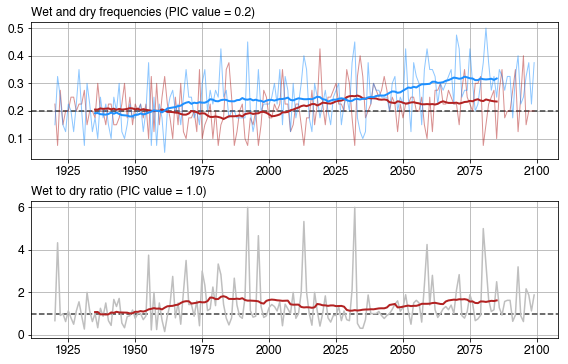

In [21]:
lat_idx = 9
lon_idx = 17

plot_this1 = all_hist_rcp_dry_40mean[:,lat_idx,lon_idx]
plot_this2 = all_hist_rcp_wet_40mean[:,lat_idx,lon_idx]
plot_this1_rolling = pandas.Series(plot_this1).rolling(window=30, center=True).mean()
plot_this2_rolling = pandas.Series(plot_this2).rolling(window=30, center=True).mean()

fontsize=12

fig,ax = mp.subplots(2,1)
fig.set_size_inches(8,5)

ax[0].axhline(y=0.2, c='0.25', ls='--')

ax[0].plot(numpy.arange(1920,2100), plot_this1, c='firebrick', lw=1, alpha=0.5)
ax[0].plot(numpy.arange(1920,2100), plot_this2, c='dodgerblue', lw=1, alpha=0.5)
ax[0].plot(numpy.arange(1920,2100), plot_this1_rolling, c='firebrick', lw=2)
ax[0].plot(numpy.arange(1920,2100), plot_this2_rolling, c='dodgerblue', lw=2)

ax[0].text(x=0,y=1.02,s='Wet and dry frequencies (PIC value = 0.2)', transform=ax[0].transAxes, fontsize=fontsize, ha='left', va='bottom')
ax[0].tick_params(labelsize=fontsize)
ax[0].grid()




plot_this = all_hist_rcp_wet_to_dry_ratio[:,lat_idx,lon_idx]
plot_this_rolling = pandas.Series(plot_this).rolling(window=30, center=True).mean()

ax[1].axhline(y=1, c='0.25', ls='--')

#ax.plot(numpy.arange(1920,2100), whiplash_hist_rcp_dry_40mean[:,9,17])
#ax.plot(numpy.arange(1920,2100), whiplash_hist_rcp_wet_40mean[:,9,17])
ax[1].plot(numpy.arange(1920,2100), plot_this, c='0.75')
ax[1].plot(numpy.arange(1920,2100), plot_this_rolling, c='firebrick', lw=2)

ax[1].text(x=0,y=1.02,s='Wet to dry ratio (PIC value = 1.0)', transform=ax[1].transAxes, fontsize=fontsize, ha='left', va='bottom')
ax[1].tick_params(labelsize=fontsize)
ax[1].grid()

fig.tight_layout(h_pad=2)

# Save PIC events as netcdf file

In [195]:
# ========= save netcdf files of -1,1 whiplash values for hist+RCP8.5
year_list = numpy.arange(403,2201)
time_datetime = numpy.array(([datetime.datetime(i,1,15) for i in year_list]))
time_nc = netCDF4.date2num(time_datetime, units='days since 402-01-01', calendar='standard')





# save hist clim
filename = 'time_series_pic_dry20_wet80_events.nc'

if os.path.exists(filename):
    print('file exists')
    os.remove(filename)

ncfile = netCDF4.Dataset(filename, 'w', format='NETCDF4')

time_dim = ncfile.createDimension('time', None)
time_var = ncfile.createVariable('time', 'f4', ('time',))
time_var[:] = time_nc
time_var.units = 'days since 402-01-01'

lat_dim = ncfile.createDimension('lat', PRECT_nlat)
lat_var = ncfile.createVariable('lat', 'f4', ('lat',))
lat_var[:] = PRECT_lat
lat_var.units = 'degrees North'

lon_dim = ncfile.createDimension('lon', PRECT_nlon)
lon_var = ncfile.createVariable('lon', 'f4', ('lon',))
lon_var[:] = PRECT_lon
lon_var.units = 'degrees East'

# ens_dim = ncfile.createDimension('ensemble', len(ensemble_names))
# ens_var = ncfile.createVariable('ensemble', 'f4', ('ensemble',))
# ens_var[:] = ensemble_names
# ens_var.units = 'NCAR LENS ensemble member'

# whiplash_events_var = ncfile.createVariable('whiplash_events', 'f4', ('time','ensemble','lat','lon',))
# whiplash_events_var.units = 'a 20/80 whiplash event is when a gridpoint has a -1 followed by a +1'
# whiplash_events_var[:] = whiplash_hist_rcp_markers.reshape((180,40,PRECT_nlat,PRECT_nlon))

all_dry_events_var = ncfile.createVariable('all_dry_events', 'f4', ('time','lat','lon',))
all_dry_events_var.units = 'all dry events, not just whiplash (seasonal totals falling below 20th percentil PIC) are marked by a -1'
all_dry_events_var[:] = all_pic_dry

all_wet_events_var = ncfile.createVariable('all_wet_events', 'f4', ('time','lat','lon',))
all_wet_events_var.units = 'all dry events, not just whiplash (seasonal totals falling below 20th percentil PIC) are marked by a +1'
all_wet_events_var[:] = all_pic_wet

ncfile.close()


file exists


In [196]:
LA_pic_dry = all_pic_dry[:,LA_lat_idx,LA_lon_idx]
LA_pic_dry_list = time_datetime[LA_pic_dry[:].astype(bool)]

SF_pic_dry = all_pic_dry[:,SF_lat_idx,SF_lon_idx]
SF_pic_dry_list = time_datetime[SF_pic_dry[:].astype(bool)]

LA_pic_wet = all_pic_wet[:,LA_lat_idx,LA_lon_idx]
LA_pic_wet_list = time_datetime[LA_pic_wet[:].astype(bool)]

SF_pic_wet = all_pic_wet[:,SF_lat_idx,SF_lon_idx]
SF_pic_wet_list = time_datetime[SF_pic_wet[:].astype(bool)]

In [202]:
LA_pic_wet_years = [t.year for t in LA_pic_wet_list]
SF_pic_wet_years = [t.year for t in SF_pic_wet_list]

LA_pic_dry_years = [t.year for t in LA_pic_dry_list]
SF_pic_dry_years = [t.year for t in SF_pic_dry_list]

In [203]:
LA_dry_df = pandas.DataFrame({'PIC':LA_pic_dry_years})
SF_dry_df = pandas.DataFrame({'PIC':SF_pic_dry_years})
LA_wet_df = pandas.DataFrame({'PIC':LA_pic_wet_years})
SF_wet_df = pandas.DataFrame({'PIC':SF_pic_wet_years})

In [204]:
LA_dry_df.to_csv('LA_20percent_dry_years_PIC.csv')
SF_dry_df.to_csv('SF_20percent_dry_years_PIC.csv')
LA_wet_df.to_csv('LA_80percent_wet_years_PIC.csv')
SF_wet_df.to_csv('SF_80percent_wet_years_PIC.csv')

In [205]:
list_2080_hist_rcp = [LA_dry_df.values[:,0],SF_dry_df.values[:,0],LA_wet_df.values[:,0],SF_wet_df.values[:,0]]
# create list of equally-sized arrays
max_nrows = max([i.size for i in list_2080_hist_rcp])

list_2080_hist_rcp_samesize = [numpy.zeros((max_nrows))*numpy.nan for i in range(list_2080_hist_rcp.__len__())]
for i in range(list_2080_hist_rcp_samesize.__len__()):
    list_2080_hist_rcp_samesize[i][0:list_2080_hist_rcp[i].size] = list_2080_hist_rcp[i]

In [206]:
max_nrows

360

In [207]:
# save as netcdf files
filename = 'PIC_2080_years.nc'

if os.path.exists(filename):
    print('file exists')
    os.remove(filename)

ncfile = netCDF4.Dataset(filename, 'w', format='NETCDF4')

year_dim = ncfile.createDimension('year', None)
year_var = ncfile.createVariable('year', 'f4', ('year'))
year_var[:] = numpy.arange(max_nrows)

# ens_dim = ncfile.createDimension('ensemble', 1)
# ens_var = ncfile.createVariable('ensemble', 'f4', ('ensemble',))
# ens_var[:] = ensemble_names
# ens_var.units = 'NCAR LENS ensemble member (ONLY ONE for preindustrial control)'

data_var = ncfile.createVariable('LA_dry', 'f4', ('year'), fill_value=numpy.nan)
data_var.units = 'Year of end of NDJFM season of extreme event'
data_var[:] = list_2080_hist_rcp_samesize[0]

data_var = ncfile.createVariable('SF_dry', 'f4', ('year'), fill_value=numpy.nan)
data_var.units = 'Year of end of NDJFM season of extreme event'
data_var[:] = list_2080_hist_rcp_samesize[1]

data_var = ncfile.createVariable('LA_wet', 'f4', ('year'), fill_value=numpy.nan)
data_var.units = 'Year of end of NDJFM season of extreme event'
data_var[:] = list_2080_hist_rcp_samesize[2]

data_var = ncfile.createVariable('SF_wet', 'f4', ('year'), fill_value=numpy.nan)
data_var.units = 'Year of end of NDJFM season of extreme event'
data_var[:] = list_2080_hist_rcp_samesize[3]

ncfile.close()

file exists


# Save hist and rcp wet/dry events as netcdf file

In [186]:
# ========= save netcdf files of -1,1 whiplash values for hist+RCP8.5
year_list = numpy.arange(1921,2101)
time_datetime = numpy.array(([datetime.datetime(i,1,15) for i in year_list]))
time_nc = netCDF4.date2num(time_datetime, units='days since 1920-01-01', calendar='standard')





# save hist clim
filename = 'time_series_hist_rcp_dry20_wet80_events.nc'

if os.path.exists(filename):
    print('file exists')
    os.remove(filename)

ncfile = netCDF4.Dataset(filename, 'w', format='NETCDF4')

time_dim = ncfile.createDimension('time', None)
time_var = ncfile.createVariable('time', 'f4', ('time',))
time_var[:] = time_nc
time_var.units = 'days since 1920-01-01'

lat_dim = ncfile.createDimension('lat', PRECT_nlat)
lat_var = ncfile.createVariable('lat', 'f4', ('lat',))
lat_var[:] = PRECT_lat
lat_var.units = 'degrees North'

lon_dim = ncfile.createDimension('lon', PRECT_nlon)
lon_var = ncfile.createVariable('lon', 'f4', ('lon',))
lon_var[:] = PRECT_lon
lon_var.units = 'degrees East'

ens_dim = ncfile.createDimension('ensemble', len(ensemble_names))
ens_var = ncfile.createVariable('ensemble', 'f4', ('ensemble',))
ens_var[:] = ensemble_names
ens_var.units = 'NCAR LENS ensemble member'

#whiplash_events_var = ncfile.createVariable('whiplash_events', 'f4', ('time','ensemble','lat','lon',))
#whiplash_events_var.units = 'a 20/80 whiplash event is when a gridpoint has a -1 followed by a +1'
#whiplash_events_var[:] = whiplash_hist_rcp_markers.reshape((180,40,PRECT_nlat,PRECT_nlon))

all_dry_events_var = ncfile.createVariable('all_dry_events', 'f4', ('time','ensemble','lat','lon',))
all_dry_events_var.units = 'all dry events, not just whiplash (seasonal totals falling below 20th percentil PIC) are marked by a -1'
all_dry_events_var[:] = all_hist_rcp_dry

all_wet_events_var = ncfile.createVariable('all_wet_events', 'f4', ('time','ensemble','lat','lon',))
all_wet_events_var.units = 'all dry events, not just whiplash (seasonal totals falling below 20th percentil PIC) are marked by a +1'
all_wet_events_var[:] = all_hist_rcp_wet

ncfile.close()


file exists


In [187]:
print(all_hist_rcp_dry.shape)

LA_hist_rcp_dry = all_hist_rcp_dry[:,:,LA_lat_idx,LA_lon_idx]
LA_hist_rcp_dry_list = [time_datetime[LA_hist_rcp_dry[:,ens].astype(bool)] for ens in range(40)]

SF_hist_rcp_dry = all_hist_rcp_dry[:,:,SF_lat_idx,SF_lon_idx]
SF_hist_rcp_dry_list = [time_datetime[SF_hist_rcp_dry[:,ens].astype(bool)] for ens in range(40)]

LA_hist_rcp_wet = all_hist_rcp_wet[:,:,LA_lat_idx,LA_lon_idx]
LA_hist_rcp_wet_list = [time_datetime[LA_hist_rcp_wet[:,ens].astype(bool)] for ens in range(40)]

SF_hist_rcp_wet = all_hist_rcp_wet[:,:,SF_lat_idx,SF_lon_idx]
SF_hist_rcp_wet_list = [time_datetime[SF_hist_rcp_wet[:,ens].astype(bool)] for ens in range(40)]

(180, 40, 26, 25)


In [188]:
LA_hist_rcp_dry_years = [ [t.year for t in ENS] for ENS in LA_hist_rcp_dry_list ]
SF_hist_rcp_dry_years = [ [t.year for t in ENS] for ENS in SF_hist_rcp_dry_list ]

LA_hist_rcp_wet_years = [ [t.year for t in ENS] for ENS in LA_hist_rcp_wet_list ]
SF_hist_rcp_wet_years = [ [t.year for t in ENS] for ENS in SF_hist_rcp_wet_list ]

In [189]:
# csv file of LA dry years, LA wet years, SF dry years, SF wet years
LA_dry_df = pandas.DataFrame({ensemble_names[0]:LA_hist_rcp_dry_years[0]})
for i in range(1,ensemble_names.__len__()):
    LA_dry_df = pandas.concat([LA_dry_df, pandas.DataFrame({ensemble_names[i]:LA_hist_rcp_dry_years[i]})], ignore_index=True, axis=1)
LA_dry_df.columns = ensemble_names

SF_dry_df = pandas.DataFrame({ensemble_names[0]:SF_hist_rcp_dry_years[0]})
for i in range(1,ensemble_names.__len__()):
    SF_dry_df = pandas.concat([SF_dry_df, pandas.DataFrame({ensemble_names[i]:SF_hist_rcp_dry_years[i]})], ignore_index=True, axis=1)
SF_dry_df.columns = ensemble_names

LA_wet_df = pandas.DataFrame({ensemble_names[0]:LA_hist_rcp_wet_years[0]})
for i in range(1,ensemble_names.__len__()):
    LA_wet_df = pandas.concat([LA_wet_df, pandas.DataFrame({ensemble_names[i]:LA_hist_rcp_wet_years[i]})], ignore_index=True, axis=1)
LA_wet_df.columns = ensemble_names

SF_wet_df = pandas.DataFrame({ensemble_names[0]:SF_hist_rcp_wet_years[0]})
for i in range(1,ensemble_names.__len__()):
    SF_wet_df = pandas.concat([SF_wet_df, pandas.DataFrame({ensemble_names[i]:SF_hist_rcp_wet_years[i]})], ignore_index=True, axis=1)
SF_wet_df.columns = ensemble_names

In [190]:
LA_dry_df.to_csv('LA_20percent_dry_years_HIST_RCP.csv')
SF_dry_df.to_csv('SF_20percent_dry_years_HIST_RCP.csv')
LA_wet_df.to_csv('LA_80percent_wet_years_HIST_RCP.csv')
SF_wet_df.to_csv('SF_80percent_wet_years_HIST_RCP.csv')

print(LA_dry_df.values.shape, SF_dry_df.values.shape, LA_wet_df.values.shape, SF_wet_df.values.shape) # use 60



(49, 40) (48, 40) (56, 40) (60, 40)


# place all dataframe arrays into a standard (samesize) array

In [191]:
list_2080_hist_rcp = [LA_dry_df.values,SF_dry_df.values,LA_wet_df.values,SF_wet_df.values]
# create list of equally-sized arrays
max_nrows = max([i.shape[0] for i in list_2080_hist_rcp])

list_2080_hist_rcp_samesize = [numpy.zeros((max_nrows,ensemble_names.__len__()))*numpy.nan for i in range(list_2080_hist_rcp.__len__())]
for i in range(list_2080_hist_rcp_samesize.__len__()):
    list_2080_hist_rcp_samesize[i][0:list_2080_hist_rcp[i].shape[0],:] = list_2080_hist_rcp[i]

In [192]:
print(list_2080_hist_rcp_samesize[0][:,0])

[ 1922.  1926.  1928.  1932.  1937.  1938.  1939.  1945.  1946.  1947.
  1953.  1955.  1957.  1961.  1966.  1968.  1975.  1979.  1980.  2000.
  2004.  2005.  2010.  2012.  2020.  2024.  2027.  2031.  2034.  2035.
  2036.  2041.  2042.  2047.  2055.  2063.  2066.  2071.  2072.  2074.
  2075.  2076.  2078.  2085.  2086.  2091.  2092.  2093.  2096.    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan]


# save year occurrences of extremes as nc files

In [193]:
LA_dry_df.values.shape[0]

49

In [194]:
# save as netcdf files
filename = 'HIST_RCP_2080_years.nc'

if os.path.exists(filename):
    print('file exists')
    os.remove(filename)

ncfile = netCDF4.Dataset(filename, 'w', format='NETCDF4')

year_dim = ncfile.createDimension('year', None)
year_var = ncfile.createVariable('year', 'f4', ('year'))
year_var[:] = numpy.arange(max_nrows)

ens_dim = ncfile.createDimension('ensemble', len(ensemble_names))
ens_var = ncfile.createVariable('ensemble', 'f4', ('ensemble',))
ens_var[:] = ensemble_names
ens_var.units = 'NCAR LENS ensemble member'

data_var = ncfile.createVariable('LA_dry', 'f4', ('year','ensemble'), fill_value=numpy.nan)
data_var.units = 'Year of end of NDJFM season of extreme event'
data_var[:] = list_2080_hist_rcp_samesize[0]

data_var = ncfile.createVariable('SF_dry', 'f4', ('year','ensemble'), fill_value=numpy.nan)
data_var.units = 'Year of end of NDJFM season of extreme event'
data_var[:] = list_2080_hist_rcp_samesize[1]

data_var = ncfile.createVariable('LA_wet', 'f4', ('year','ensemble'), fill_value=numpy.nan)
data_var.units = 'Year of end of NDJFM season of extreme event'
data_var[:] = list_2080_hist_rcp_samesize[2]

data_var = ncfile.createVariable('SF_wet', 'f4', ('year','ensemble'), fill_value=numpy.nan)
data_var.units = 'Year of end of NDJFM season of extreme event'
data_var[:] = list_2080_hist_rcp_samesize[3]

ncfile.close()

file exists


# Save years that represent end-of-season 80th or 20th percentile event

# Saving CSV files

## separate csv files for:
* all wet
* all dry
* wet/dry ratios

# wet frequency only

In [23]:
print(all_hist_rcp_wet.shape)
print(all_hist_rcp_dry_40mean.shape)

(180, 40, 26, 25)
(180, 26, 25)


# LA

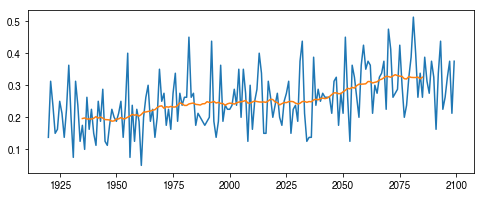

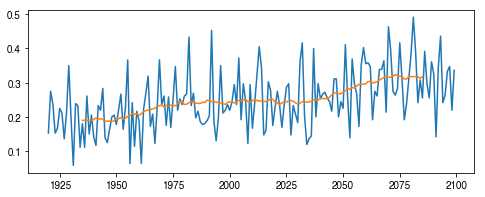

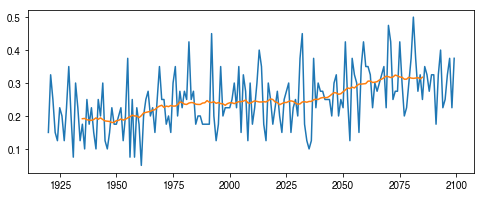

In [24]:
wet_frequency_LA = all_hist_rcp_wet[:,:,LA_lat_idx,LA_lon_idx-1:LA_lon_idx+1]

# calculate mean perc change (gpm = grid point mean)
wet_frequency_LA_gpm = numpy.mean(wet_frequency_LA, axis=2)

# 180yr percent change time series for 100yr wet, 100yr dry, 80/20 whipLAsh
column_names = ['Likelihood of ensmble having >80th perc. wet season'] + ensemble_names

fig,ax = mp.subplots()
fig.set_size_inches(8,3)
all_ens_mean = numpy.mean(wet_frequency_LA_gpm, axis=1)
#mp.plot(all_ens_mean)
ax.plot(numpy.arange(1920,2100), all_ens_mean)
ax.plot(numpy.arange(1920,2100), pandas.Series( all_ens_mean ).rolling(window=30, center=True).mean())

df_array = numpy.column_stack((all_ens_mean, wet_frequency_LA_gpm))
df_array = pandas.DataFrame(df_array, columns=column_names, index=time_datetime)
df_array.to_csv('wet_frequency_LA_2gdpts.csv')

# ==================================================

wet_frequency_LA = all_hist_rcp_wet[:,:,LA_lat_idx-1:LA_lat_idx+2,LA_lon_idx-1:LA_lon_idx+2]

# calculate mean perc change (gpm = grid point mean)
wet_frequency_LA_gpm = numpy.mean(wet_frequency_LA, axis=2)
wet_frequency_LA_gpm = numpy.mean(wet_frequency_LA_gpm, axis=2)

# 180yr percent change time series for 100yr wet, 100yr dry, 80/20 whipLAsh
column_names = ['Mean percent change'] + ensemble_names

fig,ax = mp.subplots()
fig.set_size_inches(8,3)
all_ens_mean = numpy.mean(wet_frequency_LA_gpm, axis=1)
ax.plot(numpy.arange(1920,2100), all_ens_mean)
ax.plot(numpy.arange(1920,2100), pandas.Series( all_ens_mean ).rolling(window=30, center=True).mean())

df_array = numpy.column_stack((all_ens_mean, wet_frequency_LA_gpm))
df_array = pandas.DataFrame(df_array, columns=column_names, index=time_datetime)
df_array.to_csv('wet_frequency_LA_3x3gdpts.csv')

# ==================================================

wet_frequency_LA = all_hist_rcp_wet[:,:,LA_lat_idx,LA_lon_idx]

# calculate mean perc change (gpm = grid point mean)
wet_frequency_LA_gpm = numpy.copy(wet_frequency_LA)

# 180yr percent change time series for 100yr wet, 100yr dry, 80/20 whipLAsh
column_names = ['Mean percent change'] + ensemble_names

fig,ax = mp.subplots()
fig.set_size_inches(8,3)
all_ens_mean = numpy.mean(wet_frequency_LA_gpm, axis=1)
ax.plot(numpy.arange(1920,2100), all_ens_mean)
ax.plot(numpy.arange(1920,2100), pandas.Series( all_ens_mean ).rolling(window=30, center=True).mean())

df_array = numpy.column_stack((all_ens_mean, wet_frequency_LA_gpm))
df_array = pandas.DataFrame(df_array, columns=column_names, index=time_datetime)
df_array.to_csv('wet_frequency_LA_1gdpt.csv')

# SF

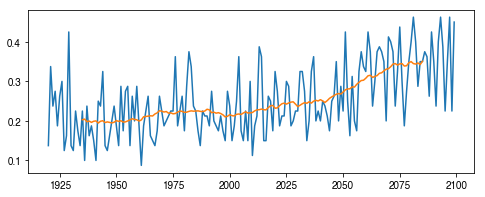

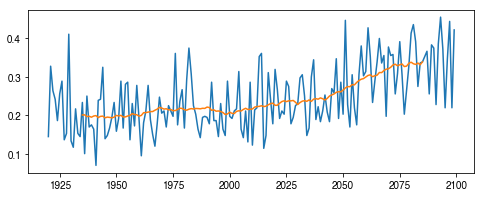

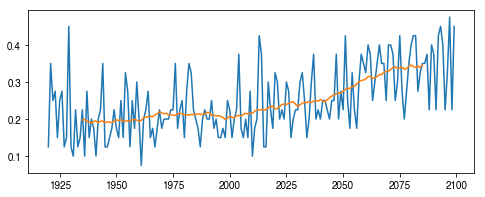

In [25]:
wet_frequency_SF = all_hist_rcp_wet[:,:,SF_lat_idx,SF_lon_idx-1:SF_lon_idx+1]

# calculate mean perc change (gpm = grid point mean)
wet_frequency_SF_gpm = numpy.mean(wet_frequency_SF, axis=2)

# 180yr percent change time series for 100yr wet, 100yr dry, 80/20 whipSFsh
column_names = ['Likelihood of ensmble having >80th perc. wet season'] + ensemble_names

fig,ax = mp.subplots()
fig.set_size_inches(8,3)
all_ens_mean = numpy.mean(wet_frequency_SF_gpm, axis=1)
#mp.plot(all_ens_mean)
ax.plot(numpy.arange(1920,2100), all_ens_mean)
ax.plot(numpy.arange(1920,2100), pandas.Series( all_ens_mean ).rolling(window=30, center=True).mean())

df_array = numpy.column_stack((all_ens_mean, wet_frequency_SF_gpm))
df_array = pandas.DataFrame(df_array, columns=column_names, index=time_datetime)
df_array.to_csv('wet_frequency_SF_2gdpts.csv')

# ==================================================

wet_frequency_SF = all_hist_rcp_wet[:,:,SF_lat_idx-1:SF_lat_idx+2,SF_lon_idx-1:SF_lon_idx+2]

# calculate mean perc change (gpm = grid point mean)
wet_frequency_SF_gpm = numpy.mean(wet_frequency_SF, axis=2)
wet_frequency_SF_gpm = numpy.mean(wet_frequency_SF_gpm, axis=2)

# 180yr percent change time series for 100yr wet, 100yr dry, 80/20 whipSFsh
column_names = ['Mean percent change'] + ensemble_names

fig,ax = mp.subplots()
fig.set_size_inches(8,3)
all_ens_mean = numpy.mean(wet_frequency_SF_gpm, axis=1)
ax.plot(numpy.arange(1920,2100), all_ens_mean)
ax.plot(numpy.arange(1920,2100), pandas.Series( all_ens_mean ).rolling(window=30, center=True).mean())

df_array = numpy.column_stack((all_ens_mean, wet_frequency_SF_gpm))
df_array = pandas.DataFrame(df_array, columns=column_names, index=time_datetime)
df_array.to_csv('wet_frequency_SF_3x3gdpts.csv')

# ==================================================

wet_frequency_SF = all_hist_rcp_wet[:,:,SF_lat_idx,SF_lon_idx]

# calculate mean perc change (gpm = grid point mean)
wet_frequency_SF_gpm = numpy.copy(wet_frequency_SF)

# 180yr percent change time series for 100yr wet, 100yr dry, 80/20 whipSFsh
column_names = ['Mean percent change'] + ensemble_names

fig,ax = mp.subplots()
fig.set_size_inches(8,3)
all_ens_mean = numpy.mean(wet_frequency_SF_gpm, axis=1)
ax.plot(numpy.arange(1920,2100), all_ens_mean)
ax.plot(numpy.arange(1920,2100), pandas.Series( all_ens_mean ).rolling(window=30, center=True).mean())

df_array = numpy.column_stack((all_ens_mean, wet_frequency_SF_gpm))
df_array = pandas.DataFrame(df_array, columns=column_names, index=time_datetime)
df_array.to_csv('wet_frequency_SF_1gdpt.csv')

# LA

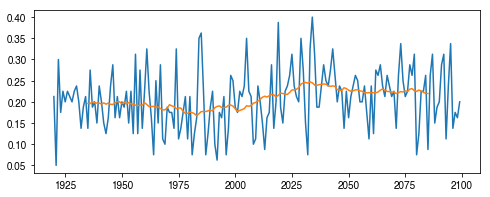

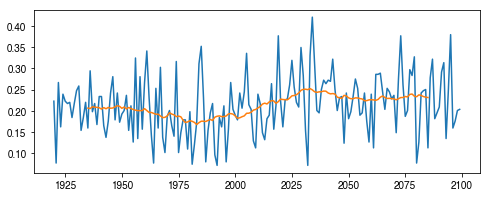

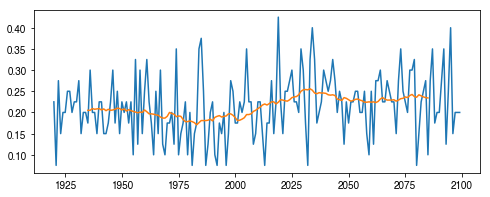

In [26]:
dry_frequency_LA = all_hist_rcp_dry[:,:,LA_lat_idx,LA_lon_idx-1:LA_lon_idx+1]

# calculate mean perc change (gpm = grid point mean)
dry_frequency_LA_gpm = numpy.mean(dry_frequency_LA, axis=2)

# 180yr percent change time series for 100yr wet, 100yr dry, 80/20 whipLAsh
column_names = ['Likelihood of ensmble having >80th perc. wet season'] + ensemble_names

fig,ax = mp.subplots()
fig.set_size_inches(8,3)
all_ens_mean = numpy.mean(dry_frequency_LA_gpm, axis=1)
#mp.plot(all_ens_mean)
ax.plot(numpy.arange(1920,2100), all_ens_mean)
ax.plot(numpy.arange(1920,2100), pandas.Series( all_ens_mean ).rolling(window=30, center=True).mean())

df_array = numpy.column_stack((all_ens_mean, dry_frequency_LA_gpm))
df_array = pandas.DataFrame(df_array, columns=column_names, index=time_datetime)
df_array.to_csv('dry_frequency_LA_2gdpts.csv')

# ==================================================

dry_frequency_LA = all_hist_rcp_dry[:,:,LA_lat_idx-1:LA_lat_idx+2,LA_lon_idx-1:LA_lon_idx+2]

# calculate mean perc change (gpm = grid point mean)
dry_frequency_LA_gpm = numpy.mean(dry_frequency_LA, axis=2)
dry_frequency_LA_gpm = numpy.mean(dry_frequency_LA_gpm, axis=2)

# 180yr percent change time series for 100yr wet, 100yr dry, 80/20 whipLAsh
column_names = ['Mean percent change'] + ensemble_names

fig,ax = mp.subplots()
fig.set_size_inches(8,3)
all_ens_mean = numpy.mean(dry_frequency_LA_gpm, axis=1)
ax.plot(numpy.arange(1920,2100), all_ens_mean)
ax.plot(numpy.arange(1920,2100), pandas.Series( all_ens_mean ).rolling(window=30, center=True).mean())

df_array = numpy.column_stack((all_ens_mean, dry_frequency_LA_gpm))
df_array = pandas.DataFrame(df_array, columns=column_names, index=time_datetime)
df_array.to_csv('dry_frequency_LA_3x3gdpts.csv')

# ==================================================

dry_frequency_LA = all_hist_rcp_dry[:,:,LA_lat_idx,LA_lon_idx]

# calculate mean perc change (gpm = grid point mean)
dry_frequency_LA_gpm = numpy.copy(dry_frequency_LA)

# 180yr percent change time series for 100yr wet, 100yr dry, 80/20 whipLAsh
column_names = ['Mean percent change'] + ensemble_names

fig,ax = mp.subplots()
fig.set_size_inches(8,3)
all_ens_mean = numpy.mean(dry_frequency_LA_gpm, axis=1)
ax.plot(numpy.arange(1920,2100), all_ens_mean)
ax.plot(numpy.arange(1920,2100), pandas.Series( all_ens_mean ).rolling(window=30, center=True).mean())

df_array = numpy.column_stack((all_ens_mean, dry_frequency_LA_gpm))
df_array = pandas.DataFrame(df_array, columns=column_names, index=time_datetime)
df_array.to_csv('dry_frequency_LA_1gdpt.csv')

# SF

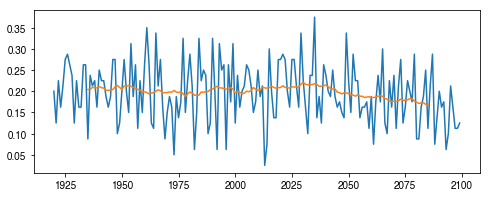

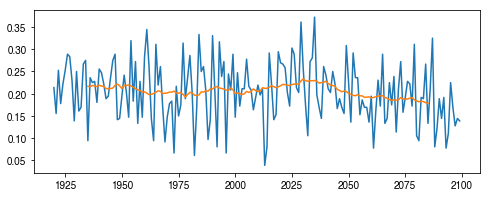

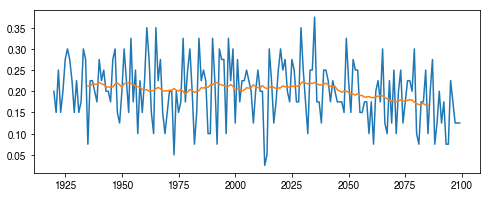

In [27]:
dry_frequency_SF = all_hist_rcp_dry[:,:,SF_lat_idx,SF_lon_idx-1:SF_lon_idx+1]

# calculate mean perc change (gpm = grid point mean)
dry_frequency_SF_gpm = numpy.mean(dry_frequency_SF, axis=2)

# 180yr percent change time series for 100yr wet, 100yr dry, 80/20 whipSFsh
column_names = ['Likelihood of ensmble having >80th perc. wet season'] + ensemble_names

fig,ax = mp.subplots()
fig.set_size_inches(8,3)
all_ens_mean = numpy.mean(dry_frequency_SF_gpm, axis=1)
#mp.plot(all_ens_mean)
ax.plot(numpy.arange(1920,2100), all_ens_mean)
ax.plot(numpy.arange(1920,2100), pandas.Series( all_ens_mean ).rolling(window=30, center=True).mean())

df_array = numpy.column_stack((all_ens_mean, dry_frequency_SF_gpm))
df_array = pandas.DataFrame(df_array, columns=column_names, index=time_datetime)
df_array.to_csv('dry_frequency_SF_2gdpts.csv')

# ==================================================

dry_frequency_SF = all_hist_rcp_dry[:,:,SF_lat_idx-1:SF_lat_idx+2,SF_lon_idx-1:SF_lon_idx+2]

# calculate mean perc change (gpm = grid point mean)
dry_frequency_SF_gpm = numpy.mean(dry_frequency_SF, axis=2)
dry_frequency_SF_gpm = numpy.mean(dry_frequency_SF_gpm, axis=2)

# 180yr percent change time series for 100yr wet, 100yr dry, 80/20 whipSFsh
column_names = ['Mean percent change'] + ensemble_names

fig,ax = mp.subplots()
fig.set_size_inches(8,3)
all_ens_mean = numpy.mean(dry_frequency_SF_gpm, axis=1)
ax.plot(numpy.arange(1920,2100), all_ens_mean)
ax.plot(numpy.arange(1920,2100), pandas.Series( all_ens_mean ).rolling(window=30, center=True).mean())

df_array = numpy.column_stack((all_ens_mean, dry_frequency_SF_gpm))
df_array = pandas.DataFrame(df_array, columns=column_names, index=time_datetime)
df_array.to_csv('dry_frequency_SF_3x3gdpts.csv')

# ==================================================

dry_frequency_SF = all_hist_rcp_dry[:,:,SF_lat_idx,SF_lon_idx]

# calculate mean perc change (gpm = grid point mean)
dry_frequency_SF_gpm = numpy.copy(dry_frequency_SF)

# 180yr percent change time series for 100yr wet, 100yr dry, 80/20 whipSFsh
column_names = ['Mean percent change'] + ensemble_names

fig,ax = mp.subplots()
fig.set_size_inches(8,3)
all_ens_mean = numpy.mean(dry_frequency_SF_gpm, axis=1)
ax.plot(numpy.arange(1920,2100), all_ens_mean)
ax.plot(numpy.arange(1920,2100), pandas.Series( all_ens_mean ).rolling(window=30, center=True).mean())

df_array = numpy.column_stack((all_ens_mean, dry_frequency_SF_gpm))
df_array = pandas.DataFrame(df_array, columns=column_names, index=time_datetime)
df_array.to_csv('dry_frequency_SF_1gdpt.csv')

In [28]:
mean_ratios = all_hist_rcp_wet_40mean/all_hist_rcp_dry_40mean

/Users/baird/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


# LA

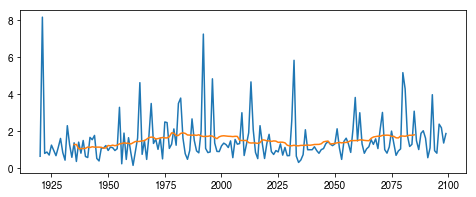

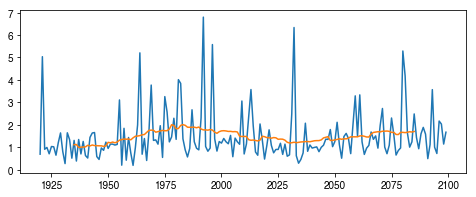

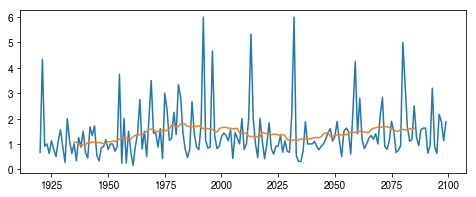

In [29]:
wet_dry_ratio_LA = mean_ratios[:,LA_lat_idx,LA_lon_idx-1:LA_lon_idx+1]

# calculate mean perc change (gpm = grid point mean)
wet_dry_ratio_LA_gpm = numpy.mean(wet_dry_ratio_LA, axis=1)

# 180yr percent change time series for 100yr wet, 100yr dry, 80/20 whipLAsh
column_names = ['Wet/dry ratio (mean across 40 ensemble members)']

fig,ax = mp.subplots()
fig.set_size_inches(8,3)
all_ens_mean = numpy.copy(wet_dry_ratio_LA_gpm)
ax.plot(numpy.arange(1920,2100), all_ens_mean)
ax.plot(numpy.arange(1920,2100), pandas.Series( all_ens_mean ).rolling(window=30, center=True).mean())

df_array = wet_dry_ratio_LA_gpm
df_array = pandas.DataFrame(df_array, columns=column_names, index=time_datetime)
df_array.to_csv('wet_dry_ratio_LA_2gdpts.csv')

# ==================================================

wet_dry_ratio_LA = mean_ratios[:,LA_lat_idx-1:LA_lat_idx+2,LA_lon_idx-1:LA_lon_idx+2]

# calculate mean perc change (gpm = grid point mean)
wet_dry_ratio_LA_gpm = numpy.mean(wet_dry_ratio_LA, axis=1)
wet_dry_ratio_LA_gpm = numpy.mean(wet_dry_ratio_LA_gpm, axis=1)

# 180yr percent change time series for 100yr wet, 100yr dry, 80/20 whipLAsh
column_names = ['Wet/dry ratio (mean across 40 ensemble members)']

fig,ax = mp.subplots()
fig.set_size_inches(8,3)
all_ens_mean = numpy.copy(wet_dry_ratio_LA_gpm)
ax.plot(numpy.arange(1920,2100), all_ens_mean)
ax.plot(numpy.arange(1920,2100), pandas.Series( all_ens_mean ).rolling(window=30, center=True).mean())

df_array = wet_dry_ratio_LA_gpm
df_array = pandas.DataFrame(df_array, columns=column_names, index=time_datetime)
df_array.to_csv('wet_dry_ratio_LA_3x3gdpts.csv')

# ==================================================

wet_dry_ratio_LA = mean_ratios[:,LA_lat_idx,LA_lon_idx]

# calculate mean perc change (gpm = grid point mean)
wet_dry_ratio_LA_gpm = numpy.copy(wet_dry_ratio_LA)

# 180yr percent change time series for 100yr wet, 100yr dry, 80/20 whipLAsh
column_names = ['Wet/dry ratio (mean across 40 ensemble members)']

fig,ax = mp.subplots()
fig.set_size_inches(8,3)
all_ens_mean = numpy.copy(wet_dry_ratio_LA_gpm)
ax.plot(numpy.arange(1920,2100), all_ens_mean)
ax.plot(numpy.arange(1920,2100), pandas.Series( all_ens_mean ).rolling(window=30, center=True).mean())

df_array = wet_dry_ratio_LA_gpm
df_array = pandas.DataFrame(df_array, columns=column_names, index=time_datetime)
df_array.to_csv('wet_dry_ratio_LA_1gdpt.csv')

# SF

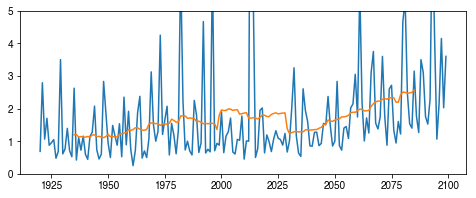

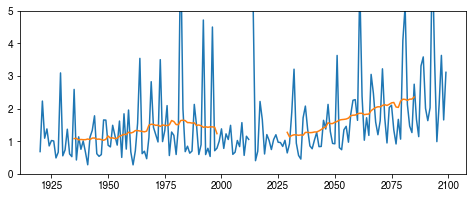

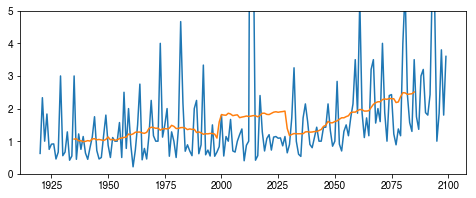

In [30]:
wet_dry_ratio_SF = mean_ratios[:,SF_lat_idx,SF_lon_idx-1:SF_lon_idx+1]

# calculate mean perc change (gpm = grid point mean)
wet_dry_ratio_SF_gpm = numpy.mean(wet_dry_ratio_SF, axis=1)

# 180yr percent change time series for 100yr wet, 100yr dry, 80/20 whipSFsh
column_names = ['Wet/dry ratio (mean across 40 ensemble members)']

fig,ax = mp.subplots()
fig.set_size_inches(8,3)
all_ens_mean = numpy.copy(wet_dry_ratio_SF_gpm)
ax.plot(numpy.arange(1920,2100), all_ens_mean)
ax.plot(numpy.arange(1920,2100), pandas.Series( all_ens_mean ).rolling(window=30, center=True).mean())
ax.set_ylim(0,5)

df_array = wet_dry_ratio_SF_gpm
df_array = pandas.DataFrame(df_array, columns=column_names, index=time_datetime)
df_array.to_csv('wet_dry_ratio_SF_2gdpts.csv')

# ==================================================

wet_dry_ratio_SF = mean_ratios[:,SF_lat_idx-1:SF_lat_idx+2,SF_lon_idx-1:SF_lon_idx+2]

# calculate mean perc change (gpm = grid point mean)
wet_dry_ratio_SF_gpm = numpy.mean(wet_dry_ratio_SF, axis=1)
wet_dry_ratio_SF_gpm = numpy.mean(wet_dry_ratio_SF_gpm, axis=1)

# 180yr percent change time series for 100yr wet, 100yr dry, 80/20 whipSFsh
column_names = ['Wet/dry ratio (mean across 40 ensemble members)']

fig,ax = mp.subplots()
fig.set_size_inches(8,3)
all_ens_mean = numpy.copy(wet_dry_ratio_SF_gpm)
ax.plot(numpy.arange(1920,2100), all_ens_mean)
ax.plot(numpy.arange(1920,2100), pandas.Series( all_ens_mean ).rolling(window=30, center=True).mean())
ax.set_ylim(0,5)

df_array = wet_dry_ratio_SF_gpm
df_array = pandas.DataFrame(df_array, columns=column_names, index=time_datetime)
df_array.to_csv('wet_dry_ratio_SF_3x3gdpts.csv')

# ==================================================

wet_dry_ratio_SF = mean_ratios[:,SF_lat_idx,SF_lon_idx]

# calculate mean perc change (gpm = grid point mean)
wet_dry_ratio_SF_gpm = numpy.copy(wet_dry_ratio_SF)

# 180yr percent change time series for 100yr wet, 100yr dry, 80/20 whipSFsh
column_names = ['Wet/dry ratio (mean across 40 ensemble members)']

fig,ax = mp.subplots()
fig.set_size_inches(8,3)
all_ens_mean = numpy.copy(wet_dry_ratio_SF_gpm)
ax.plot(numpy.arange(1920,2100), all_ens_mean)
ax.plot(numpy.arange(1920,2100), pandas.Series( all_ens_mean ).rolling(window=30, center=True).mean())
ax.set_ylim(0,5)

df_array = wet_dry_ratio_SF_gpm
df_array = pandas.DataFrame(df_array, columns=column_names, index=time_datetime)
df_array.to_csv('wet_dry_ratio_SF_1gdpt.csv')